In [1]:
#importing setup and python modules

import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import h5py

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


%load_ext autoreload
%autoreload 2
#some skeleton code is from COMPSCI 682

In [2]:
#function to load MS-COCO data

BASE_DIR = 'data/coco_captioning'

def load_coco_data(base_dir=BASE_DIR,
                   max_train=None,
                   pca_features=True):
    data = {}
    caption_file = os.path.join(base_dir, 'coco2014_captions.h5')
    with h5py.File(caption_file, 'r') as f:
        for k, v in f.items():
            data[k] = np.asarray(v)

    if pca_features:
        train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7_pca.h5')
    else:
        train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7.h5')
    with h5py.File(train_feat_file, 'r') as f:
        data['train_features'] = np.asarray(f['features'])

    if pca_features:
        val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7_pca.h5')
    else:
        val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7.h5')
    with h5py.File(val_feat_file, 'r') as f:
        data['val_features'] = np.asarray(f['features'])

    dict_file = os.path.join(base_dir, 'coco2014_vocab.json')
    with open(dict_file, 'r') as f:
        dict_data = json.load(f)
        for k, v in dict_data.items():
            data[k] = v

    train_url_file = os.path.join(base_dir, 'train2014_urls.txt')
    with open(train_url_file, 'r') as f:
        train_urls = np.asarray([line.strip() for line in f])
    data['train_urls'] = train_urls

    val_url_file = os.path.join(base_dir, 'val2014_urls.txt')
    with open(val_url_file, 'r') as f:
        val_urls = np.asarray([line.strip() for line in f])
    data['val_urls'] = val_urls

    # Maybe subsample the training data
    if max_train is not None:
        num_train = data['train_captions'].shape[0]
        mask = np.random.randint(num_train, size=max_train)
        data['train_captions'] = data['train_captions'][mask]
        data['train_image_idxs'] = data['train_image_idxs'][mask]

    return data

In [16]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


In [4]:
#returns the caption for an image by converting token ids to words

def decode_captions(captions, idx_to_word):
    singleton = False
    if captions.ndim == 1:
        singleton = True
        captions = captions[None]
    decoded = []
    N, T = captions.shape
    for i in range(N):
        words = []
        for t in range(T):
            word = idx_to_word[captions[i, t]]
            if word != '<NULL>':
                words.append(word)
            if word == '<END>':
                break
        decoded.append(' '.join(words))
    if singleton:
        decoded = decoded[0]
    return decoded

In [5]:
#dont want to use the entire dataset, sample a batch

def sample_coco_minibatch(data, batch_size=100, split='train'):
    split_size = data['%s_captions' % split].shape[0]
    mask = np.random.choice(split_size, batch_size)
    captions = data['%s_captions' % split][mask]
    image_idxs = data['%s_image_idxs' % split][mask]
    image_features = data['%s_features' % split][image_idxs]
    urls = data['%s_urls' % split][image_idxs]
    return captions, image_features, urls

In [6]:
import urllib.request, urllib.error, urllib.parse, os, tempfile
from scipy.misc import imread, imresize

def image_from_url(url):
    """
    Read an image from a URL. Returns a numpy array with the pixel data.
    We write the image to a temporary file then read it back. Kinda gross.
    """
    try:
        f = urllib.request.urlopen(url)
        _, fname = tempfile.mkstemp()
        with open(fname, 'wb') as ff:
            ff.write(f.read())
        img = imread(fname)
        os.remove(fname)
        return img
    except urllib.error.URLError as e:
        print('URL Error: ', e.reason, url)
    except urllib.error.HTTPError as e:
        print('HTTP Error: ', e.code, url)

/home/jaskaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


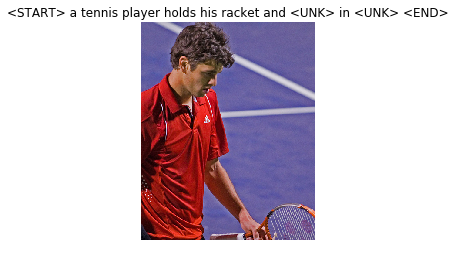

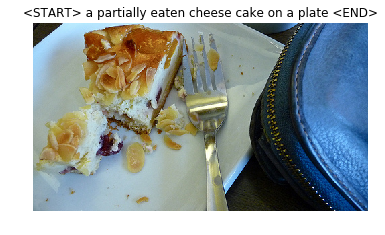

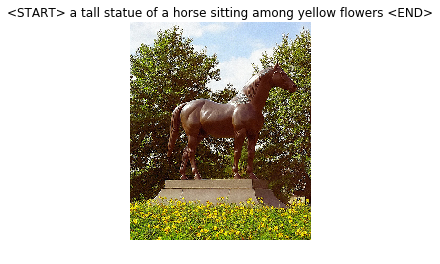

In [14]:
#lets look at some samples

batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

In [11]:
from src.classifiers.rnn import CaptioningRNN
from src.captioning_solver import CaptioningSolver

(Iteration 1 / 100) loss: 81.050650
(Iteration 11 / 100) loss: 42.687293
(Iteration 21 / 100) loss: 23.295894
(Iteration 31 / 100) loss: 13.397221
(Iteration 41 / 100) loss: 5.122885
(Iteration 51 / 100) loss: 1.292287
(Iteration 61 / 100) loss: 1.090780
(Iteration 71 / 100) loss: 0.330104
(Iteration 81 / 100) loss: 0.142553
(Iteration 91 / 100) loss: 0.121125


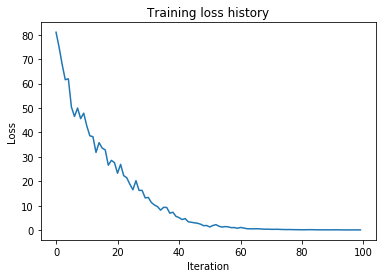

In [17]:
#overfitting our model on a small subset of data

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

/home/jaskaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


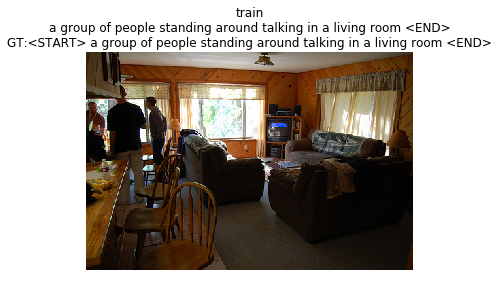

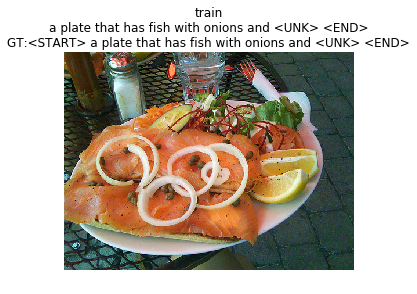

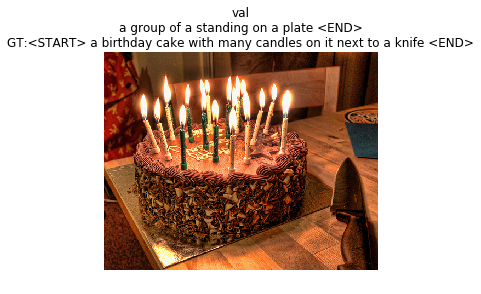

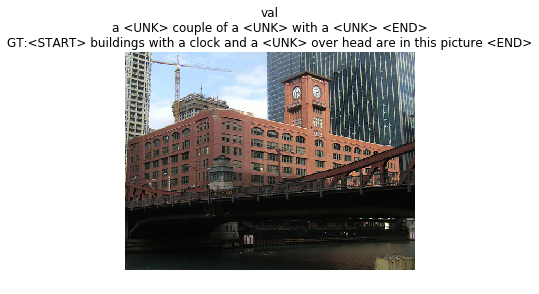

In [19]:
#train and validation results
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()